## Capstone Project -  Customer Segmentation using Unsupervised ML

### Steps taken in the Project
#### - Importing Data
#### - EDA 
#### - Variable Imputation / Feature Engineering
#### - Model Selection
#### - Summary of Findings

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats
from scipy.stats import boxcox
import datetime as dt


from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importing file using encoding="unicode escape"

df = pd.read_csv('C:/Users/opera/Downloads/OnlineRetail.csv', encoding= 'unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
# Here is the summary of file

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
# describe() provides us statistical description of numerical features in our dataset

df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
# Checking percentage of null values using filter for only null values in the dataset 

df.isnull().mean()[df.isnull().sum()>0]*100

Description     0.268311
CustomerID     24.926694
dtype: float64

In [6]:
# There are about 25% of null values in CustomerID column. I'm going to drop all the NaN values from the dataset 
# since CustomerID can not be imputed using statistical methods.

df.dropna(subset=['CustomerID'], axis=0, inplace=True)

In [7]:
# Dropping all negative UnitPrice and Quantity from dataset since this can be a case of cancelled orders.

df = df[df.UnitPrice > 0]
df = df[df.Quantity > 0]

In [8]:
# Converting Invoice date to date-time format and extracting only Date

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Date'] = df['InvoiceDate'].dt.strftime('%Y-%m')

In [9]:
# Checking number of unique customers present in this dataset

df.CustomerID.value_counts().count()

4338

In [10]:
# Checking dataset after making above changes

df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,2010-12
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,2010-12
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,2010-12
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,2010-12
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,2010-12


### Variable Imputation

In [11]:
# Creating a new feature 'TotalSales' from Quantity & UnitPrice features

df['TotalSales'] = df['Quantity'] * df['UnitPrice']

#### RFM analysis
RFM is a very popular method to segmentize customers behaviour. We require only Recency, Frequency and Moneytary value to segmentize customers based on their transcational history.

The last invoice date was 2011-12-9 and we shall use the next day to calculate recency.

In [12]:
NOW = dt.date(2011,12,10)
df['Date'] = pd.DatetimeIndex(df.InvoiceDate).date

In [13]:
df_recency = df.groupby(['CustomerID'], as_index = False)['Date'].max()
df_recency.columns = ['CustomerID', 'Last_Purchase_Date']
df_recency['Recency'] = df_recency.Last_Purchase_Date.apply(lambda x: (NOW - x).days)
df_recency.head()

,CustomerID,Last_Purchase_Date,Recency
0,12346.0,2011-01-18,326
1,12347.0,2011-12-07,3
2,12348.0,2011-09-25,76
3,12349.0,2011-11-21,19
4,12350.0,2011-02-02,311


In [14]:
df_monetary = df.groupby('CustomerID').agg({'InvoiceNo' : lambda x: len(x),
                                           'TotalSales': lambda x: x.sum()})
df_monetary.rename(columns = {'InvoiceNo' : 'Frequency', 
                              'TotalSales' : 'Monetary'}, inplace = True)
df_monetary.head()

,Frequency,Monetary
CustomerID,,
12346.0,1,77183.60
12347.0,182,4310.00
12348.0,31,1797.24
12349.0,73,1757.55
12350.0,17,334.40


In [15]:
# Merging two tables to form RFM table

RFM_table = df_recency.merge(df_monetary, left_on='CustomerID', right_on = 'CustomerID')
RFM_table.drop(['Last_Purchase_Date'], axis=1, inplace=True)
RFM_table.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,3,182,4310.00
2,12348.0,76,31,1797.24
3,12349.0,19,73,1757.55
4,12350.0,311,17,334.40


Before going into segmentation, I would like to split customers using quantiles based on the Recency, Frequency and Monetary values. I shall assign 1 for the highest value and 4 for the lowest value. A final RFM score will be obtained by combining individual RFM score numbers. This will proivde us an insight about value of each customer. 

In [16]:
# Now we shall split the metrics into segments using quantiles. We will assign a score from 1 to 4 to each Recency
# Frequency and Monetary columns

quantiles = RFM_table.quantile(q=[0.25,0.50,0.75])
quantiles = quantiles.to_dict()

In [17]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    if x <= d[p][0.50]:
        return 2
    if x <= d[p][0.75]:
        return 3
    else:
        return 4


In [18]:
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    if x <= d[p][0.50]:
        return 3
    if x <= d[p][0.75]:
        return 2
    else:
        return 1

In [19]:
RFM_table['R_quartile'] = RFM_table['Recency'].apply(RScore, args=('Recency', quantiles))
RFM_table['F_quartile'] = RFM_table['Frequency'].apply(FMScore, args=('Frequency', quantiles))
RFM_table['M_quartile'] = RFM_table['Monetary'].apply(FMScore, args=('Monetary', quantiles))
RFM_table.head()

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile
0,12346.0,326,1,77183.60,4,4,1
1,12347.0,3,182,4310.00,1,1,1
2,12348.0,76,31,1797.24,3,3,1
3,12349.0,19,73,1757.55,2,2,1
4,12350.0,311,17,334.40,4,4,3


In [20]:
RFM_table['RFM_Segment'] = RFM_table.R_quartile.map(str)+RFM_table.F_quartile.map(str)+RFM_table.M_quartile.map(str)
RFM_table['RFM_Score'] = RFM_table[['R_quartile','F_quartile','M_quartile']].sum(axis=1)

In [21]:
RFM_table.head()

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
0,12346.0,326,1,77183.60,4,4,1,441,9
1,12347.0,3,182,4310.00,1,1,1,111,3
2,12348.0,76,31,1797.24,3,3,1,331,7
3,12349.0,19,73,1757.55,2,2,1,221,5
4,12350.0,311,17,334.40,4,4,3,443,11


In [22]:
print('Best customers: ', len(RFM_table[RFM_table.RFM_Segment == '111']))
print('Loyal customers: ', len(RFM_table[RFM_table['F_quartile'] == 1]))
print('Big Spenders: ', len(RFM_table[RFM_table['M_quartile'] == 1]))
print('Almost Lost: ', len(RFM_table[RFM_table['RFM_Segment'] == '134']))
print('Lost customers: ', len(RFM_table[RFM_table['RFM_Segment'] == '344']))
print('Lost Bad Customers: ', len(RFM_table[RFM_table['RFM_Segment'] == '444']))

Best customers:  440
Loyal customers:  1080
Big Spenders:  1085
Almost Lost:  25
Lost customers:  181
Lost Bad Customers:  385


In [23]:
# List of Best Customers with ID

RFM_table[['CustomerID', 'RFM_Segment']][RFM_table.RFM_Segment =='111'].head()

,CustomerID,RFM_Segment
1,12347.0,111
15,12362.0,111
56,12417.0,111
61,12423.0,111
71,12433.0,111


In [24]:
# List of Loyal Customers with ID

RFM_table[['CustomerID', 'M_quartile']][RFM_table.M_quartile ==1].head()

,CustomerID,M_quartile
0,12346.0,1
1,12347.0,1
2,12348.0,1
3,12349.0,1
5,12352.0,1


In [25]:
# List of Big Spenders with ID

RFM_table[['CustomerID', 'F_quartile']][RFM_table.F_quartile ==1].head()

,CustomerID,F_quartile
1,12347.0,1
10,12357.0,1
12,12359.0,1
13,12360.0,1
15,12362.0,1


Above analysis shows number of Best Customers, Loyal Customers, Big Spenders and on the other hand Lost Customers, Almost
Lost Customers and Lost Bad customers. This will help marketing team to come up with plans to apprecite good customers and 
help retaining the good customers from being churned out.

#### We are going to use K-means clusering for segmentation. K-means gives best results when data distribution is not skewed and data is standardized, i.e. mean is 0 and standard deviation is 1

In [26]:
# filtering a final version of RFM table considering only Recency, Frequency and Monetary columns

RFM_table = RFM_table.drop(['R_quartile', 'F_quartile', 'M_quartile', 'RFM_Segment', 'RFM_Score'], axis = 1)
RFM_table.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,3,182,4310.00
2,12348.0,76,31,1797.24
3,12349.0,19,73,1757.55
4,12350.0,311,17,334.40


Recency's: Skew: 1.2453948317057284, : SkewtestResult(statistic=26.60351236555474, pvalue=6.181721752536432e-156)


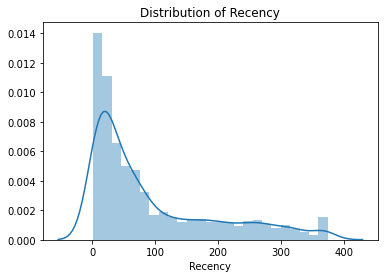

In [27]:
## Function to check skewness in the variables. 

def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

check_skew(RFM_table, 'Recency')

Frequency's: Skew: 18.09990377360193, : SkewtestResult(statistic=83.56042637346283, pvalue=0.0)


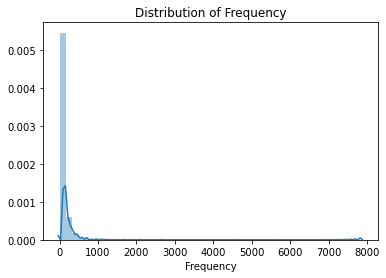

In [28]:
check_skew(RFM_table, 'Frequency')

Monetary's: Skew: 19.31827038422538, : SkewtestResult(statistic=84.99544548748324, pvalue=0.0)


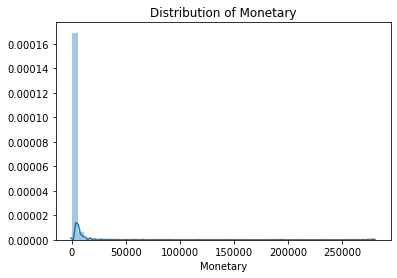

In [29]:
check_skew(RFM_table, 'Monetary')

Recency's: Skew: 5.486713376712565, : SkewtestResult(statistic=26.60351236555474, pvalue=6.181721752536432e-156)


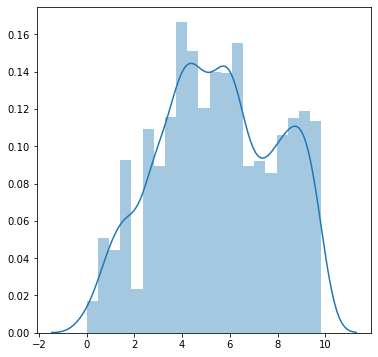

In [30]:
# Above distribution plot shows that the data is highly skewed. Threfore, we shall perform Boxcox transformations 
# to reduce the skewness of each variable.

def remove_skew(df_skew, column):
    skew = boxcox(df_skew[column])[0]
    plt.figure(figsize = (6, 6))
    sns.distplot(skew)
    skewtest = stats.skewtest(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew.mean(), skewtest))
    plt.show()
    return

remove_skew(RFM_table, 'Recency')

Frequency's: Skew: 4.10568139421389, : SkewtestResult(statistic=83.56042637346283, pvalue=0.0)


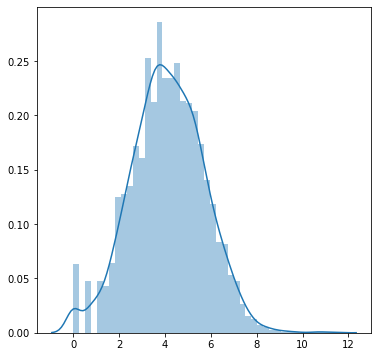

In [31]:
remove_skew(RFM_table, 'Frequency')

Monetary's: Skew: 5.023562897127294, : SkewtestResult(statistic=84.99544548748324, pvalue=0.0)


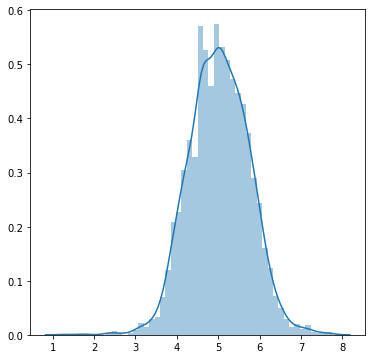

In [32]:
remove_skew(RFM_table, 'Monetary')

In [33]:
# The next step is to apply standard scalar to bring all features mean close to 0 and standard deviation to 1. Scaling is 
# important because the location of each data point on the graph is determined by considering all information associated
# with a specific customer. If any of the information is not on the same distance scale, K-means might not form meaningful
# clusters.

scaler = StandardScaler()
scaler.fit(RFM_table)
final_df = scaler.transform(RFM_table)
print(final_df.mean(axis=0).round(2))
print(final_df.std(axis=0).round(2))

[ 0. -0.  0.  0.]
[1. 1. 1. 1.]


In [34]:
final_df = pd.DataFrame(final_df, columns =RFM_table.columns)
final_df.head()

,CustomerID,Recency,Frequency,Monetary
0,-1.716073,2.329388,-0.396578,8.358668
1,-1.715492,-0.900588,0.394649,0.250966
2,-1.714911,-0.170593,-0.265435,-0.028596
3,-1.714330,-0.740589,-0.081836,-0.033012
4,-1.713749,2.179389,-0.326635,-0.191347


### Model Selection

The next step is to find the optimal number of clusters that are potentially present in the dataset. A different number of clusters gives us a different interpretation of results. To find out optimal number of clusters we shall use **Elbow Method** which gives us inertia graph to figure out optimal clusters.

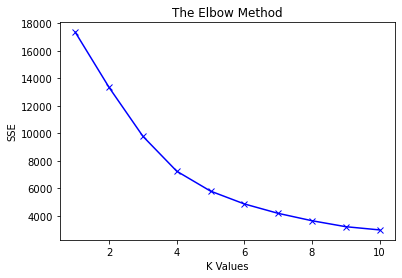

In [35]:
sse = []
k_rng = range(1, 11)
for k in k_rng:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(final_df)
    sse.append(kmeans.inertia_)
plt.title('The Elbow Method')
plt.xlabel('K Values')
plt.ylabel('SSE')
plt.plot(k_rng, sse, 'bx-')
# sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

Above graph shows that four is the optimal cluster value. We take the best parameter by looking at where the k-value has a linear trend on the next consecutive k. We can choose more or less number of clusters depening on the business requirements.

We shall draw **scatter plots** and **snake plots** to figure out the best number of clusters to find the best segment. 

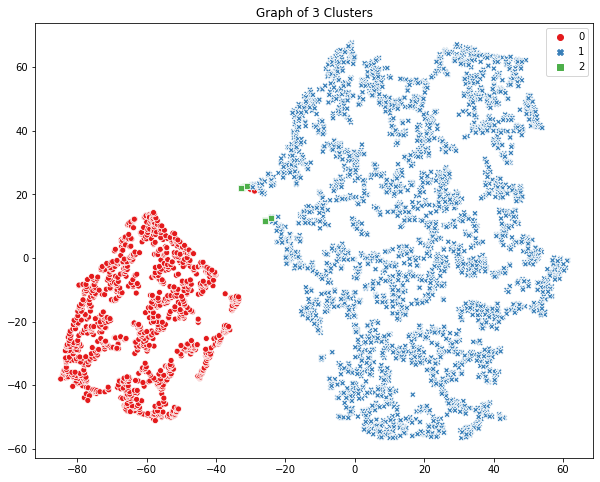

In [36]:
# Function to draw different number of clusters

def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)
# Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

plt.figure(figsize=(10, 8))
df_rfm_k3 = kmeans(final_df, 3, final_df)


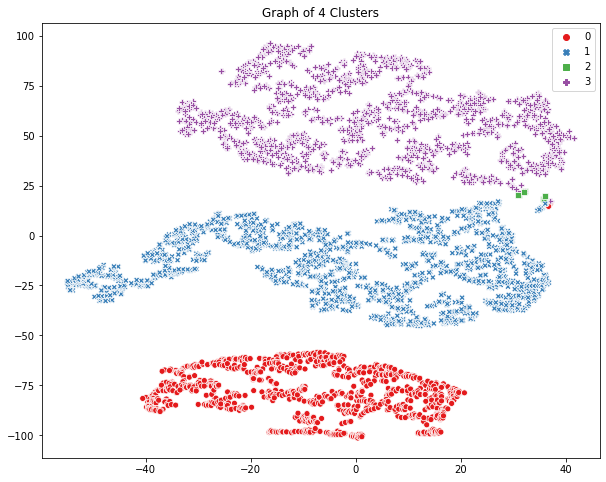

In [37]:
# Graph of 4 clusers

plt.figure(figsize=(10, 8))
df_rfm_k4 = kmeans(final_df, 4, final_df)

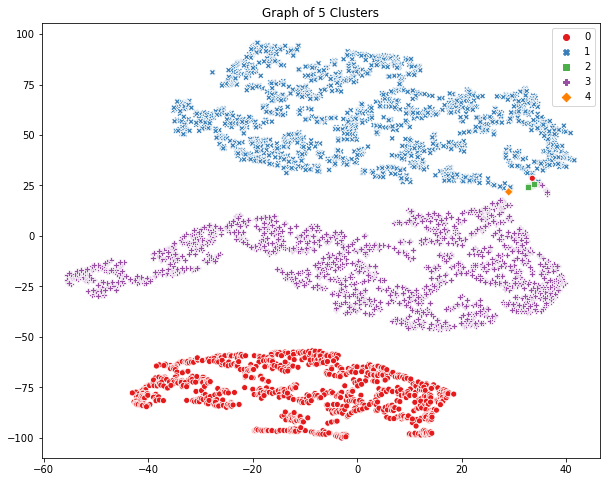

In [38]:
# Graph of 5 clusters

plt.figure(figsize=(10, 8))
df_rfm_k5 = kmeans(final_df, 5, final_df)

In [39]:
# Function to draw snake plot for different number of clusters:

def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):
    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=RFM_table.index, 
                                       columns=RFM_table.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']
# Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'], 
                        var_name='Attribute', 
                        value_name='Value')
    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Attribute', y='Value', hue='Cluster')

    return df_melt

We shall also draw RFM value chart to inferr the best segmentation. RFM value chart will provide us different segments comprising of different numbers

In [40]:
def rfm_values(df):
    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)
    
    return df_new

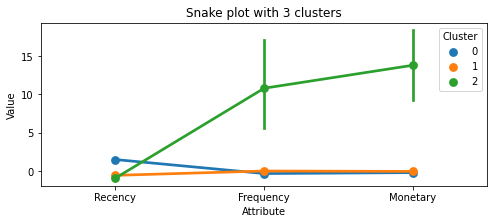

In [41]:
plt.figure(figsize=(8, 3))
plt.title('Snake plot with 3 clusters')
k3 = snake_plot(final_df, df_rfm_k3, RFM_table)

In [42]:
# RFM Value chart for 3 clusters:

rfm_values(df_rfm_k3)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0           2.0      -0.0     -0.0  1087
1          -1.0       0.0     -0.0  3238
2          -1.0      11.0     14.0    13

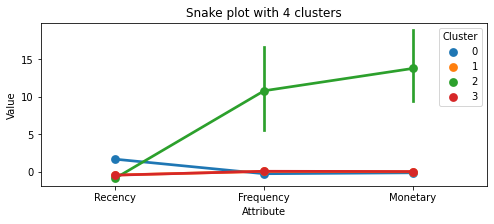

In [43]:
plt.figure(figsize=(8, 3))
plt.title('Snake plot with 4 clusters')
k4 = snake_plot(final_df, df_rfm_k4, RFM_table)

In [44]:
# RFM Value chart for 4 clusters:

rfm_values(df_rfm_k4)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0           2.0      -0.0     -0.0   953
1          -0.0       0.0     -0.0  1686
2          -1.0      11.0     14.0    13
3          -0.0       0.0      0.0  1686

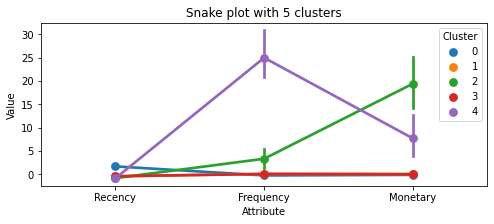

In [45]:
plt.figure(figsize=(8, 3))
plt.title('Snake plot with 5 clusters')
k5 = snake_plot(final_df, df_rfm_k5, RFM_table)

In [46]:
# RFM Value chart for 5 clusters:

rfm_values(df_rfm_k5)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0           2.0      -0.0     -0.0   953
1          -0.0       0.0      0.0  1689
2          -1.0       3.0     19.0     7
3          -0.0       0.0     -0.0  1685
4          -1.0      25.0      8.0     4

### Summary

After experimenting segmentation with different clusters, I came to conclusioin that segmentation with 3 clusters works best for this dataset. Below is the detailed analysis of customers belonging to different segments in 3 cluster analsys:

**Cluster 1:** Customers belonging to this cluster are the oldest with least frequency and least monetary value

**Cluster 2:** Customers belonging to this cluster are comparatively newer but with almost same frequency and monetary value.

**Cluster 3:** Customers belonging to this cluster are the most recent with higher frequency and monetary value than cluster 1 and 3.